## Import Libraries

In [19]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [23]:
"""
Whole life 2x multiplier:
100k: $1,450  
150k: $2,175
200k: $2,860
250k: $$3,575

Whole life 3x multiplier: 
100k: $1,216.69
150k: $1,770
200k: $2,360
250k: $2,950.02

Multi claim ci to 65: 
100k: $738.85
150k: $1,108.28
200k: $1,477.70
250k: $1,847.13
"""

'\nWhole life 2x multiplier:\n100k: $1,450  \n150k: $2,175\n200k: $2,860\n250k: $$3,575\n\nWhole life 3x multiplier: \n100k: $1,216.69\n150k: $1,770\n200k: $2,360\n250k: $2,950.02\n\nMulti claim ci to 65: \n100k: $738.85\n150k: $1,108.28\n200k: $1,477.70\n250k: $1,847.13\n'

## Load Life table data

In [2]:
try:
    # Works when running as a script (e.g., python main.py)
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # Works when running in a Jupyter Notebook
    current_dir = os.getcwd()
    
csv_file_path = os.path.join(current_dir, 'life_table.csv')

## Find the coefficients based on a Gompertz distribution for Morbidity

In [3]:
def fit_incidence_curve():
    def gompertz_law(x, a, b):
        return a * np.exp(b * x)

    # 2. Data taken from Singapore Cancer Registry Annual Report 2023, we adjust for other CI with a 1.3x multiplier
    x_data = np.array([15, 35, 45, 55, 65, 75, 85])
    y_data_raw = np.array([24.7, 65.7, 158.4, 412.9, 1076.8, 2098.6, 2889.7])
    
    # Convert to Probability (0-1) AND Apply 1.3x Loading for other CI
    y_data_adjusted = (y_data_raw / 100000) * 1.3
    
    params, _ = curve_fit(gompertz_law, x_data, y_data_adjusted, p0=[0.0001, 0.08])

    a_opt, b_opt = params
    print(f"Fitted Parameters: a={a_opt:.6f}, b={b_opt:.4f}")
    
    return a_opt, b_opt
        

fit_incidence_curve()

Fitted Parameters: a=0.000379, b=0.0547


(np.float64(0.0003794596030546379), np.float64(0.05465870342621226))

### Plot morbidity curve for visualisation

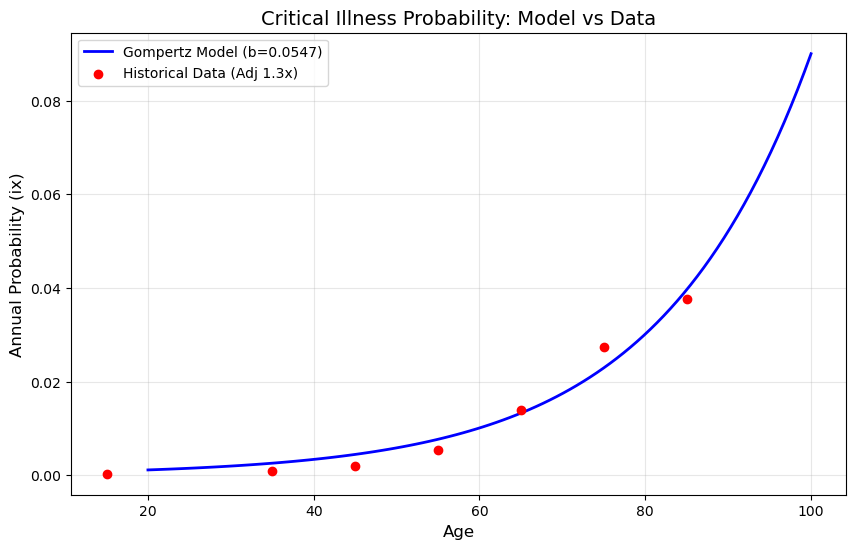

In [4]:
def plot_morbidity_curve():
    # 1. Your Calibrated Parameters
    a = 0.000379
    b = 0.0547

    # 2. The Historical Anchors (for comparison)
    # Midpoints of age buckets
    ages_raw = np.array([15, 35, 45, 55, 65, 75, 85])
    # Rates per 100k -> Probability -> Adjusted 1.3x for total CI
    rates_raw = np.array([24.7, 65.7, 158.4, 412.9, 1076.8, 2098.6, 2889.7])
    probs_raw = (rates_raw / 100000) * 1.3

    # 3. Generate the Smooth Model Curve
    # Create a smooth range of ages from 20 to 100
    x_model = np.linspace(20, 100, 100)
    y_model = a * np.exp(b * x_model)

    # 4. Plotting
    plt.figure(figsize=(10, 6))
    
    # Plot the Model (Blue Line)
    plt.plot(x_model, y_model, label=f'Gompertz Model (b={b})', color='blue', linewidth=2)
    
    # Plot the Anchors (Red Dots)
    plt.scatter(ages_raw, probs_raw, color='red', label='Historical Data (Adj 1.3x)', zorder=5)

    # Formatting
    plt.title('Critical Illness Probability: Model vs Data', fontsize=14)
    plt.xlabel('Age', fontsize=12)
    plt.ylabel('Annual Probability (ix)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Show the plot
    plt.show()

plot_morbidity_curve()

## Define Mortality (Death) and Morbidity (Critical Illness) Models and Classes

In [5]:
# ==========================================
# 1. MORTALITY MODEL (The Data Loader)
# ==========================================
class MortalityModel:
    def __init__(self, csv_path):
        """
        Loads SAS Table. Assumes CSV columns: 'Age Last', 'S0408DTPD Male'
        """
        # Load and clean data
        raw_df = pd.read_csv(csv_path)
        self.df = raw_df[['Age Last', 'S0408DTPD Male']].copy()
        self.df.columns = ['age', 'qx']
        self.df.set_index('age', inplace=True)
        
        # Normalize: Input is Per 1000 -> Output is Probability (0-1)
        self.df['qx'] = self.df['qx'] / 1000

    def get_qx(self, age):
        if age > 99: return 1.0
        try:
            return self.df.at[age, 'qx']
        except KeyError:
            return 0.0

# ==========================================
# 2. MORBIDITY MODEL (The Math Formula)
# ==========================================
class MorbidityModel:
    def __init__(self, a=0.000379, b=0.0547):
        """
        Gompertz Law: Rate = a * exp(b * age)
        Calibrated to Singapore Cancer Registry 2019-2023.
        """
        self.a = a
        self.b = b

    def get_ix(self, age):
        # Calculate raw rate
        prob = self.a * np.exp(self.b * age)
        # Cap at 50% to prevent explosion at age 110
        return min(prob, 0.5)

## Engine to simulate the stacked probabilities of death and CI, with a max claim of 2 CI's

In [6]:
# ==========================================
# 3. SIMULATION ENGINE (The Generator of Simulated Lifetimes)
# ==========================================
class SimulationEngine:
    def __init__(self, mort_model, morb_model):
        self.mort = mort_model
        self.morb = morb_model
        
    def simulate_one_life(self, start_age=25, max_age=100):
        age = start_age
        is_alive = True
        history = []
        claims_count = 0
        max_claims = 2 # Multi-Pay limit
        
        while is_alive and age < max_age:
            # Get probabilities
            q_x = self.mort.get_qx(age)
            i_x = self.morb.get_ix(age)
            
            # Penalty: If sick, death is more likely
            if claims_count > 0:
                q_x *= 1.5 
            
            # Logic: Single Dice Roll for competing risks
            roll = np.random.random()
            
            # Zone A: Death
            if roll < q_x:
                history.append({'age': age, 'event': 'death'})
                is_alive = False
            
            # Zone B: Critical Illness (Survival implied for this year)
            elif roll < (q_x + i_x):
                if claims_count < max_claims:
                    history.append({'age': age, 'event': 'ci_claim'})
                    claims_count += 1
            
            age += 1
            
        if is_alive:
            history.append({'age': max_age, 'event': 'death'})
            
        return history

    def run_cohort(self, n_sims, start_age):
        return [self.simulate_one_life(start_age) for _ in range(n_sims)]

## Engine to calculate the NPV based on the events at each age

In [20]:
# ==========================================
# 4. VALUATOR (The NPV Calculator based on Lifetime Simulations)
# ==========================================
class Valuator:
    def __init__(self, prem_wl, prem_term, sa, r_inv, r_disc):
        self.prem_wl = prem_wl
        self.prem_term = prem_term
        self.sa = sa
        self.r_inv = r_inv
        self.r_disc = r_disc

    def calculate_value(self, history, start_age):
        # Accumulators
        npv_wl = 0.0
        npv_btir = 0.0
        
        # State
        btir_fund = 0.0
        is_waived = False
        wl_terminated = False
        
        events_map = {x['age']: x['event'] for x in history}
        max_age = history[-1]['age']
        
        for age in range(start_age, max_age + 1):
            t = age - start_age
            df = 1 / ((1 + self.r_disc) ** t)
            
            # --- START OF YEAR: PREMIUMS ---
            if not is_waived:
                # Whole Life Pay
                if not wl_terminated:
                    npv_wl -= self.prem_wl * df
                
                # BTIR Pay + Invest
                npv_btir -= self.prem_term * df
                btir_fund += (self.prem_wl - self.prem_term)
            
            # --- DURING YEAR: GROWTH ---
            btir_fund *= (1 + self.r_inv)
            
            # --- END OF YEAR: EVENTS ---
            if age in events_map:
                event = events_map[age]
                
                if event == 'ci_claim':
                    # WL: Pays + Terminates
                    if not wl_terminated:
                        payout = self.sa * (1.035 ** t) # 3.5% Bonus growth
                        npv_wl += payout * df
                        wl_terminated = True
                    
                    # BTIR: Pays + Waiver
                    npv_btir += self.sa * df
                    is_waived = True
                    
                elif event == 'death':
                    # WL: Pay if active
                    if not wl_terminated:
                        payout = self.sa * (1.035 ** t)
                        npv_wl += payout * df
                    
                    # BTIR: Pay Term if < 70
                    if age < 70:
                        npv_btir += self.sa * df
                    
                    # BTIR: Always liquidate fund
                    npv_btir += btir_fund * df
                    
        return npv_wl, npv_btir

## Driver code for the simulation engine

Simulating 10000 lives...


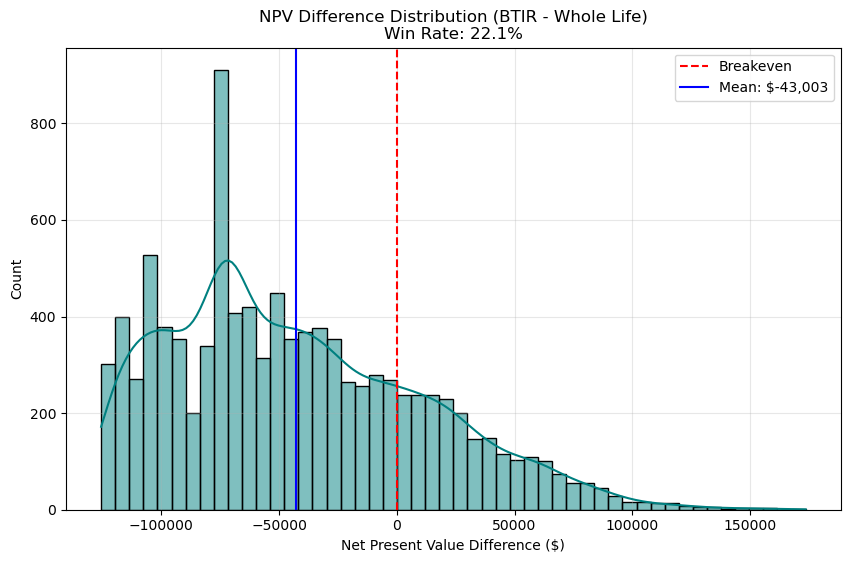

In [22]:
# ==========================================
# 5. EXECUTION (The Main Loop)
# ==========================================

# A. Init
# NOTE: Update path to your local file
mort = MortalityModel(csv_file_path) 
morb = MorbidityModel() # Uses defaults
eng = SimulationEngine(mort, morb)
val = Valuator(prem_wl=2860, prem_term=1477, sa=200000, r_inv=0.06, r_disc=0.03)

# B. Run Simulation
N_SIMS = 10000
START_AGE = 25
print(f"Simulating {N_SIMS} lives...")
cohort = eng.run_cohort(N_SIMS, START_AGE)

# C. Valuate
diffs = []
for hist in cohort:
    vwl, vbtir = val.calculate_value(hist, START_AGE)
    diffs.append(vbtir - vwl)

# D. Plot
plt.figure(figsize=(10, 6))
sns.histplot(diffs, kde=True, color='teal', bins=50)
plt.axvline(0, color='red', linestyle='--', label='Breakeven')
plt.axvline(np.mean(diffs), color='blue', linestyle='-', label=f'Mean: ${np.mean(diffs):,.0f}')
plt.title(f"NPV Difference Distribution (BTIR - Whole Life)\nWin Rate: {sum(x > 0 for x in diffs)/N_SIMS:.1%}")
plt.xlabel("Net Present Value Difference ($)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Generating 10000 lives...
Valuating portfolios...


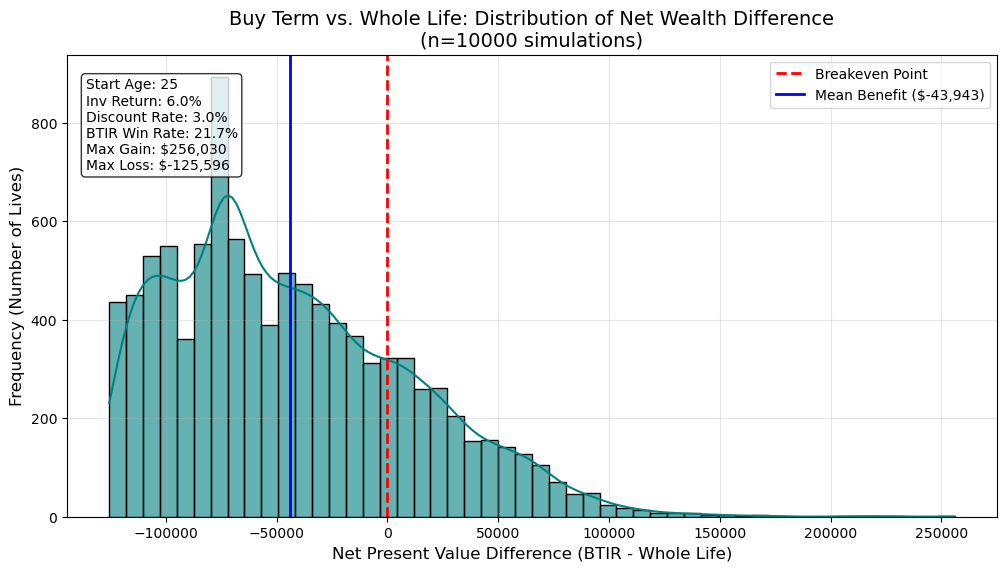

In [14]:
# --- DRIVER CODE ---
valuator = Valuator(
    prem_wl=2860,    # Whole Life Premium
    prem_term=1477,  # Multi-Claim Term Premium
    sa=200000,       # Sum Assured
    r_inv=0.06,      # 6% Market Return
    r_disc=0.03      # 3% Discount Rate
)

# --- 2. GENERATE COHORT ---
# (Assuming models are already initialized from previous cells)
print(f"Generating {N_SIMS} lives...")
cohort_histories = engine.run_cohort(n_sims=N_SIMS, start_age=START_AGE)

# --- 3. VALUATE EVERY LIFE ---
results_diff = []
wins_btir = 0

print("Valuating portfolios...")
for history in cohort_histories:
    # Calculate Value for this specific life path
    npv_wl, npv_btir = valuator.calculate_value(history, start_age=START_AGE)
    
    # The Metric: How much richer/poorer are you with BTIR?
    diff = npv_btir - npv_wl
    results_diff.append(diff)
    
    if diff > 0:
        wins_btir += 1

# --- 4. VISUALIZATION ---
plt.figure(figsize=(12, 6))

# Plot Histogram/KDE
sns.histplot(results_diff, kde=True, bins=50, color='teal', edgecolor='black', alpha=0.6)

# Add Reference Line (Breakeven)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Breakeven Point')

# Add Mean Line
avg_diff = np.mean(results_diff)
plt.axvline(avg_diff, color='blue', linestyle='-', linewidth=2, label=f'Mean Benefit (${avg_diff:,.0f})')

# Formatting
plt.title(f'Buy Term vs. Whole Life: Distribution of Net Wealth Difference\n(n={N_SIMS} simulations)', fontsize=14)
plt.xlabel('Net Present Value Difference (BTIR - Whole Life)', fontsize=12)
plt.ylabel('Frequency (Number of Lives)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Stats Box
text_str = f'\n'.join((
    f'Start Age: {START_AGE}',
    f'Inv Return: {valuator.r_inv:.1%}',
    f'Discount Rate: {valuator.r_disc:.1%}',
    f'BTIR Win Rate: {wins_btir/N_SIMS:.1%}',
    f'Max Gain: ${max(results_diff):,.0f}',
    f'Max Loss: ${min(results_diff):,.0f}'
))
plt.gca().text(0.02, 0.95, text_str, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

## Deterministic breakeven based on interest rates

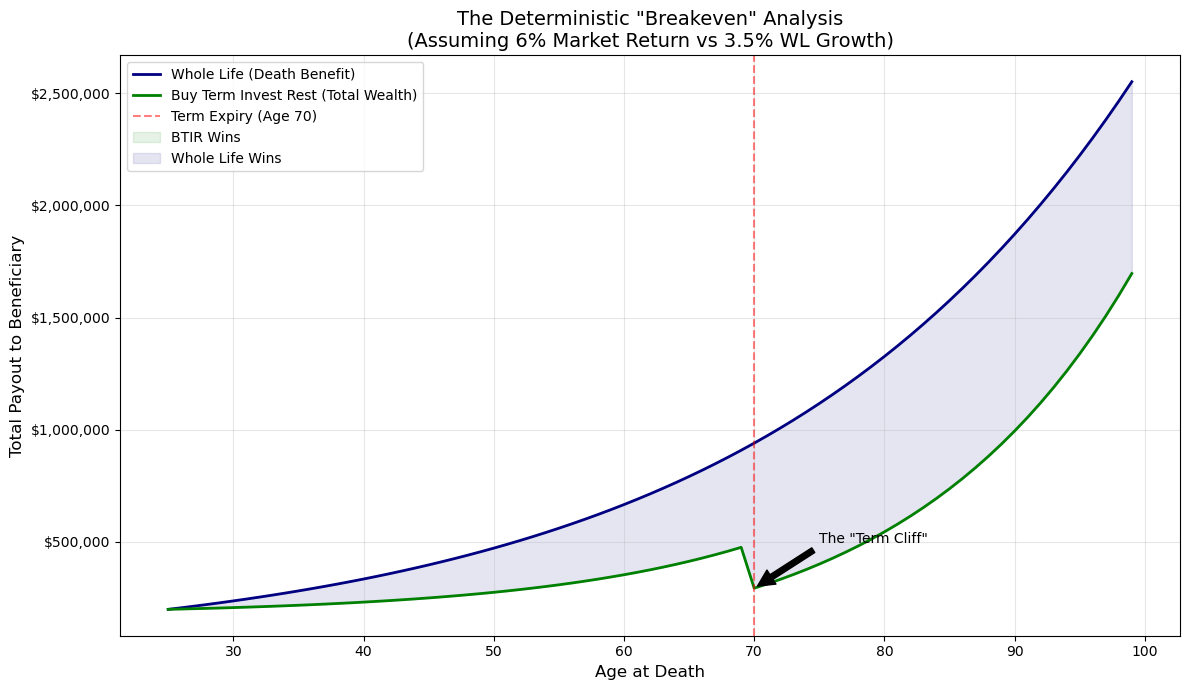

In [17]:
def plot_deterministic_breakeven():
    # --- INPUTS ---
    start_age = 25
    end_age = 99
    ages = np.arange(start_age, end_age + 1)
    years = ages - start_age
    
    # Financials
    sa = 200000
    prem_wl = 2860
    prem_term = 1477
    investable_delta = prem_wl - prem_term  # $1,383
    
    # Growth Rates
    r_inv = 0.06       # You earn 6% in the market
    r_wl_bonus = 0.035 # Insurer gives 3.5% bonus growth on SA
    term_expiry_age = 70
    
    # --- CALCULATIONS (Vectorized) ---
    
    # 1. Whole Life Value (Death Benefit)
    # Model: Base SA * (1 + bonus)^years
    wl_value = sa * (1 + r_wl_bonus)**years
    
    # 2. BTIR Value (Term + Investment)
    # A. Investment Fund Growth (Future Value of Annuity Formula)
    # FV = P * [ (1+r)^n - 1 ] / r
    fund_value = investable_delta * ((1 + r_inv)**years - 1) / r_inv
    
    # B. Term Insurance Payout
    # It is SA if age < 70, else 0
    term_payout = np.where(ages < term_expiry_age, sa, 0)
    
    # C. Total BTIR Wealth
    btir_value = fund_value + term_payout
    
    # --- PLOTTING ---
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot Lines
    ax.plot(ages, wl_value, label='Whole Life (Death Benefit)', color='navy', linewidth=2)
    ax.plot(ages, btir_value, label='Buy Term Invest Rest (Total Wealth)', color='green', linewidth=2)
    
    # Highlight the "Term Cliff"
    ax.axvline(term_expiry_age, color='red', linestyle='--', alpha=0.5, label=f'Term Expiry (Age {term_expiry_age})')
    
    # Fill areas to show "Winner"
    ax.fill_between(ages, btir_value, wl_value, where=(btir_value > wl_value), 
                    interpolate=True, color='green', alpha=0.1, label='BTIR Wins')
    ax.fill_between(ages, btir_value, wl_value, where=(btir_value < wl_value), 
                    interpolate=True, color='navy', alpha=0.1, label='Whole Life Wins')

    # Formatting
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    
    ax.set_title('The Deterministic "Breakeven" Analysis\n(Assuming 6% Market Return vs 3.5% WL Growth)', fontsize=14)
    ax.set_xlabel('Age at Death', fontsize=12)
    ax.set_ylabel('Total Payout to Beneficiary', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Annotate the "Cliff" drop
    cliff_val = btir_value[ages == term_expiry_age][0]
    ax.annotate('The "Term Cliff"', xy=(term_expiry_age, cliff_val), xytext=(term_expiry_age+5, cliff_val+200000),
                arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

plot_deterministic_breakeven()

C:\Users\Admin\AppData\Local\Temp\ipykernel_4744\3686404724.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'${x:,.0f}' for x in current_values])


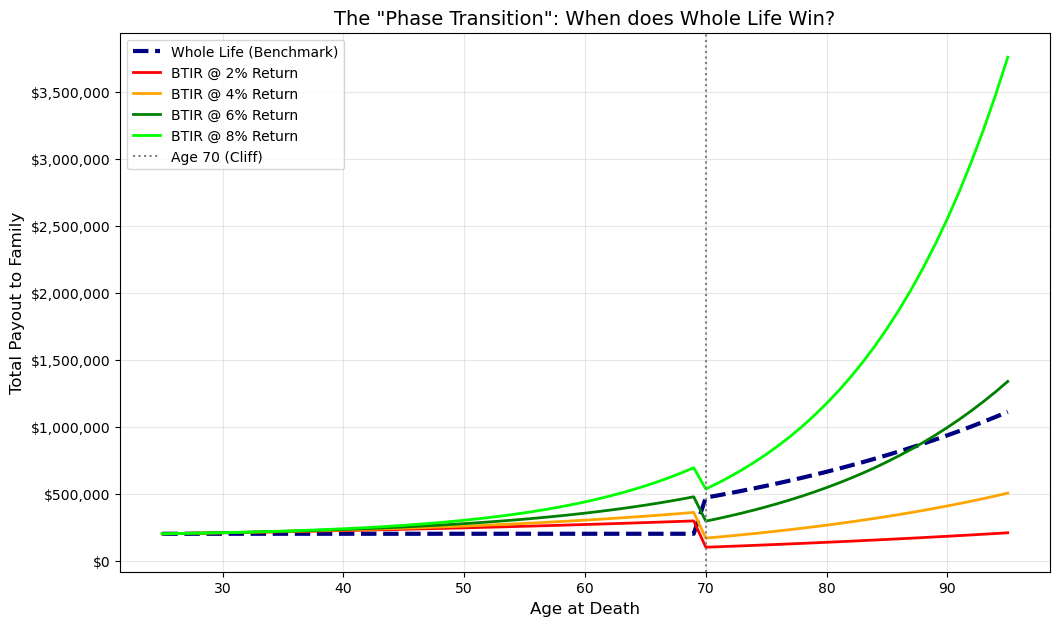

In [18]:
def plot_sensitivity_analysis():
    # --- INPUTS ---
    start_age = 25
    end_age = 95
    ages = np.arange(start_age, end_age + 1)
    years = ages - start_age
    
    # Financials (Multiplier Plan Reality)
    # WL drops coverage after Age 70 usually! Let's model that correctly.
    base_sa = 100000      # Estimated Base
    multiplier_sa = 200000 # Total with Multiplier
    term_expiry = 70      # When Multiplier/Term ends
    
    prem_wl = 2860
    prem_term = 1477
    delta = prem_wl - prem_term # $1,383
    
    # --- SCENARIOS ---
    market_rates = [0.02, 0.04, 0.06, 0.08] # 2%, 4%, 6%, 8%
    colors = ['red', 'orange', 'green', 'lime']
    
    plt.figure(figsize=(12, 7))
    
    # 1. Plot Whole Life Baseline (Approximate)
    # Assumption: Multiplier (200k) until 70, then drops to Base (100k) + Bonuses
    # Bonus growth of 3.5% on Base
    wl_payout = []
    for age in ages:
        if age < 70:
            val = multiplier_sa 
        else:
            # After 70, multiplier drops, but accumulated bonuses remain
            val = base_sa * (1.035 ** (age - start_age))
        wl_payout.append(val)
    
    plt.plot(ages, wl_payout, label='Whole Life (Benchmark)', color='navy', linewidth=3, linestyle='--')
    
    # 2. Plot BTIR for each Market Scenario
    for r, color in zip(market_rates, colors):
        # Fund Growth
        fund_values = delta * ((1 + r)**years - 1) / r
        
        # Term Payout (200k until 70, then 0)
        term_payout = np.where(ages < 70, multiplier_sa, 0)
        
        # Total Wealth
        total_wealth = fund_values + term_payout
        
        plt.plot(ages, total_wealth, label=f'BTIR @ {r*100:.0f}% Return', color=color, linewidth=2)

    # Formatting
    plt.title('The "Phase Transition": When does Whole Life Win?', fontsize=14)
    plt.xlabel('Age at Death', fontsize=12)
    plt.ylabel('Total Payout to Family', fontsize=12)
    plt.axvline(70, color='gray', linestyle=':', label='Age 70 (Cliff)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Format Y-axis to Dollars
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([f'${x:,.0f}' for x in current_values])
    
    plt.show()

plot_sensitivity_analysis()